In [2]:
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.modeling.models import EBLAbsorptionNormSpectralModel, TemplateSpectralModel, ExpCutoffPowerLawNormSpectralModel 
from astropy.io import ascii
import astropy.units as u
import matplotlib.pyplot as plt

import numpy as np

from IPython.display import display
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, SensitivityEstimator
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.maps.axes import UNIT_STRING_FORMAT

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/modeling/models/spectral.py:1394: GammapyDeprecationWarning: The default index value changed from 1.5 to 0 since v1.3
  warnings.warn(


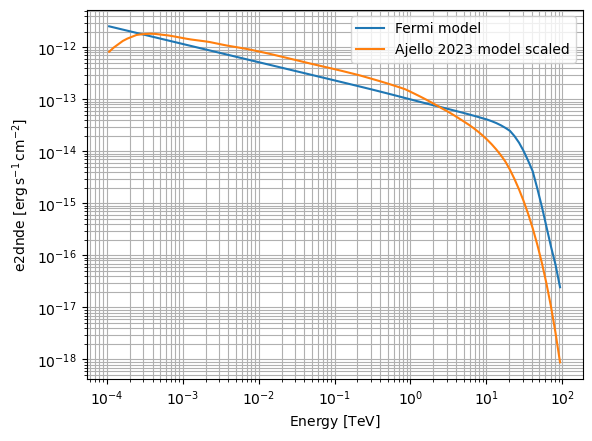

In [3]:
# Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
source_4fgl = catalog_4fgl["4FGL J0242.6-0000"]          # NGC 1068
fermi_model = source_4fgl.sky_model()

# Specify the redshift of the source
redshift = 0.00379

# Load the EBL model. Here we use the model from Dominguez, 2011
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

# The Fermi model is multiplied by the EBL to get the final model
spectral_model = fermi_model.spectral_model * ebl 

# Template spectral model. Defined by values from Ajello 2023
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Ajello_starburst/Ajello_starburst.csv")

# Getting the model in the correct units
energy = data['x'] *u.GeV
flux = data['y'] *u.GeV / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV)

flux = flux.to(u.MeV / (u.cm ** 2.0 * u.s))
flux_MeV = flux / energy_MeV**2  # divide by energy to get dN/dE

# Sort data by energy
sorted_indices = np.argsort(energy_MeV)
energy_MeV = energy_MeV[sorted_indices]
flux_MeV = flux_MeV[sorted_indices]

template_spec_model = TemplateSpectralModel(energy=energy_MeV, values=flux_MeV)

norm = ExpCutoffPowerLawNormSpectralModel(
    norm=1.5,
    reference=1 * u.TeV,
)

ecpl_norm = template_spec_model * norm

#Plotting the model
energy_bounds = [0.0001, 100] * u.TeV
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts, label="Fermi model")
ecpl_norm.plot(energy_bounds, sed_type="e2dnde", label="Ajello 2023 model scaled")
plt.legend(loc="best")
plt.grid(which="both")

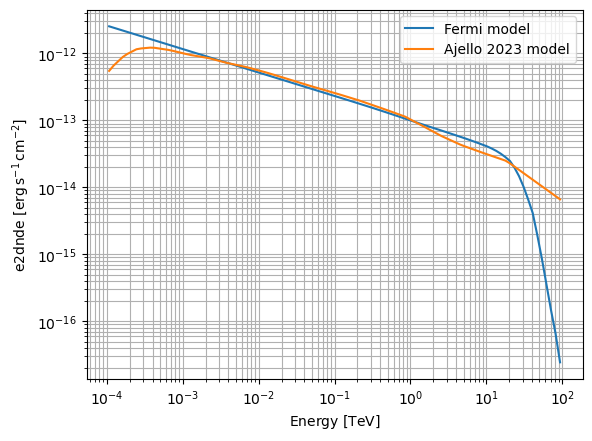

In [4]:
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts, label="Fermi model")
template_spec_model.plot(energy_bounds, sed_type="e2dnde", label="Ajello 2023 model")
plt.legend(loc="best")
plt.grid(which="both")

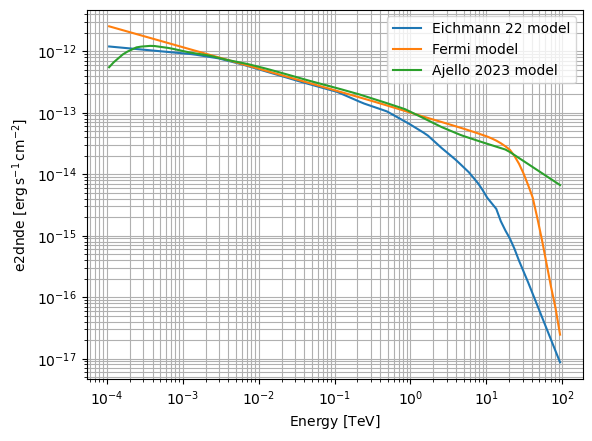

In [5]:
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Eichmann_starburst/Eichmann_starburst.csv")

energy = data['x'] *u.GeV
values = data['y'] *u.eV / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV)

values = values.to(u.MeV / (u.cm ** 2.0 * u.s))
values_MeV = values / energy_MeV**2  # divide by energy to get dN/dE


energy_bounds = [0.0001, 100] * u.TeV
template_spec_model_2 = TemplateSpectralModel(energy=energy_MeV, values=values_MeV)

template_spec_model_2.plot(energy_bounds, sed_type="e2dnde", label="Eichmann 22 model")
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts, label="Fermi model")
template_spec_model.plot(energy_bounds, sed_type="e2dnde", label="Ajello 2023 model")
plt.legend(loc="best")
plt.grid(which="both")

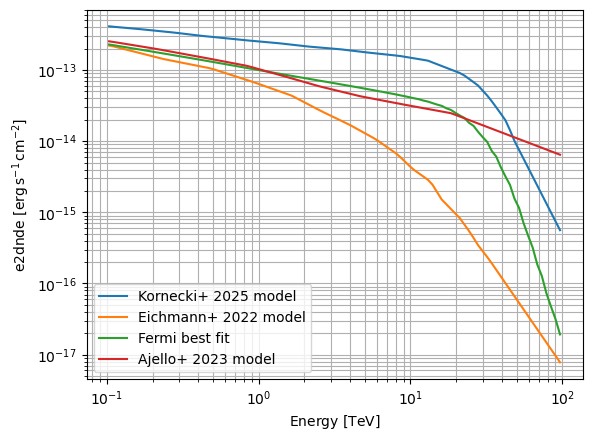

In [6]:
# Template spectral model. Defined by values from Kornecki 2025
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Kornecki_starburst/Kornecki_Starburst.csv")

energy = data['x'] *u.TeV
values = data['y'] *u.erg / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV)

values = values.to(u.MeV / (u.cm ** 2.0 * u.s))
values_MeV = values / energy_MeV**2  # divide by energy to get dN/dE


energy_bounds = [0.1, 100] * u.TeV
template_spec_model_3 = TemplateSpectralModel(energy=energy_MeV, values=values_MeV)

template_spec_model_3.plot(energy_bounds, sed_type="e2dnde", label="Kornecki+ 2025 model")
template_spec_model_2.plot(energy_bounds, sed_type="e2dnde", label="Eichmann+ 2022 model")
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts, label="Fermi best fit")
template_spec_model.plot(energy_bounds, sed_type="e2dnde", label="Ajello+ 2023 model")
plt.legend(loc="best")
plt.grid(which="both")

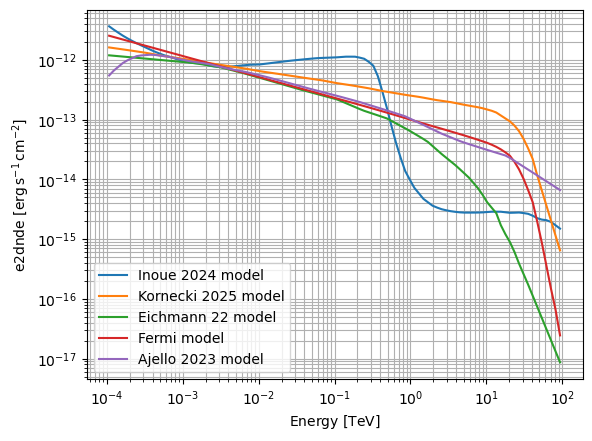

In [7]:
# Template spectral model. Defined by custom tabular values from Inoue 2024
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Inoue_2022_wind.dat")

data['Frequency[Hz]'] = 10**data['logFrequency[Hz]'] 
data['flux[ergcm^-2s^-1]'] = 10**data['logflux[ergcm^-2s^-1]']

energy_bounds = [0.0001, 100] * u.TeV
energy = data['Frequency[Hz]'] * u.Hz
values = data['flux[ergcm^-2s^-1]'] *u.erg / (u.cm **2.0 * u.s)

energy_MeV = energy.to(u.MeV, equivalencies=u.spectral())

values = values.to(u.MeV / (u.cm ** 2.0 * u.s))
values_MeV = values / energy_MeV**2  # divide by energy to get dN/dE


template_spec_model_4 = TemplateSpectralModel(energy=energy_MeV, values=values_MeV)

template_spec_model_4.plot(energy_bounds, sed_type="e2dnde", label="Inoue 2024 model")
template_spec_model_3.plot(energy_bounds, sed_type="e2dnde", label="Kornecki 2025 model")
template_spec_model_2.plot(energy_bounds, sed_type="e2dnde", label="Eichmann 22 model")
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts, label="Fermi model")
template_spec_model.plot(energy_bounds, sed_type="e2dnde", label="Ajello 2023 model")
plt.grid(which="both")
plt.legend(loc="best")

/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_44877/3778302555.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_ul = pd.read_csv('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/NGC1068_MAGIC_UL.dat', delim_whitespace=True, header=0)


<ErrorbarContainer object of 3 artists>

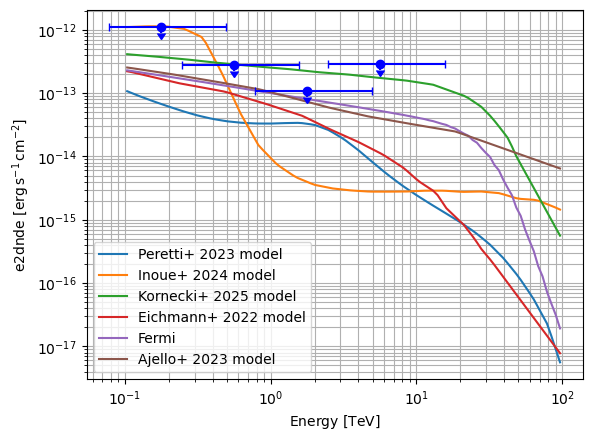

In [8]:
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/UFO/Peretti_2023_UFO.dat")

energy_bounds = [0.1, 100] * u.TeV
energy = data['Energy[MeV]'] *u.MeV
values = data['flux[MeV^-1cm^-2s^-1]'] *1.0 / (u.MeV * u.cm **2.0 * u.s)

template_spec_model_5 = TemplateSpectralModel(energy=energy, values=values)

template_spec_model_5.plot(energy_bounds, sed_type="e2dnde", label="Peretti+ 2023 model")
template_spec_model_4.plot(energy_bounds, sed_type="e2dnde", label="Inoue+ 2024 model")
template_spec_model_3.plot(energy_bounds, sed_type="e2dnde", label="Kornecki+ 2025 model")
template_spec_model_2.plot(energy_bounds, sed_type="e2dnde", label="Eichmann+ 2022 model")
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts, label="Fermi")
template_spec_model.plot(energy_bounds, sed_type="e2dnde", label="Ajello+ 2023 model")


plt.grid(which="both")
plt.legend(loc="best")

import pandas as pd

# Read the .dat file assuming whitespace-separated values.
df_ul = pd.read_csv('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/NGC1068_MAGIC_UL.dat', delim_whitespace=True, header=0)

# Rename columns for clarity
df_ul.columns = ['energy', 'energy_min', 'energy_max', 'flux_UL']

# Convert columns to numeric
df_ul['energy'] = pd.to_numeric(df_ul['energy'], errors='coerce')
df_ul['energy_min'] = pd.to_numeric(df_ul['energy_min'], errors='coerce')
df_ul['energy_max'] = pd.to_numeric(df_ul['energy_max'], errors='coerce')
df_ul['flux_UL'] = pd.to_numeric(df_ul['flux_UL'], errors='coerce')

# Convert MAGIC energy from GeV to eV (1 GeV = 1e9 eV)
df_ul['energy'] = df_ul['energy'] * 0.001
df_ul['energy_min'] = df_ul['energy_min'] * 0.001
df_ul['energy_max'] = df_ul['energy_max'] * 0.001

# We'll define a small fraction of the flux as the 'error' so that the arrow is visible.
fraction = 0.2  # 20% of the flux, for example

# Use uplims=True to draw a downward arrow from the data point
plt.errorbar(
    df_ul['energy'],
    df_ul['flux_UL'],
    yerr = fraction * df_ul['flux_UL'],
    xerr=[df_ul['energy_min'], df_ul['energy_max']],
    fmt='o',         # 'o' marker at the flux limit
    uplims=True,     # arrow indicates flux is only bounded from above
    color='blue',
    capsize=3,       # length of the error bar caps
    label='MAGIC UL'
)


